In [112]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

#2020 population of Catalonia from https://www.idescat.cat/pub/?id=aec&n=245
popCatalunya = 7722203

#Catalonia's health department data https://dadescovid.cat/descarregues
resp = urlopen("https://dadescovid.cat/static/csv/catalunya_diari_total_pob.zip")
zipfile = ZipFile(BytesIO(resp.read()))
file = zipfile.namelist()[0]
df = pd.read_csv(zipfile.open(file), sep=";")
df.head()

,NOM,CODI,DATA,SEXE,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,...,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,CATALUNYA,GLOBAL,2021-02-08,Altres,NaN,33,48,13,0,1,...,27,0,7,26,2,2,44,12,0,1
1,CATALUNYA,GLOBAL,2021-02-08,Dona,Entre 15 i 64,471,867,5239,1,1,...,63,0,37,434,25,371,775,4746,405,915
2,CATALUNYA,GLOBAL,2021-02-08,Dona,Entre 65 i 74,63,116,554,0,1,...,52,1,0,63,0,54,105,525,4,22
3,CATALUNYA,GLOBAL,2021-02-08,Dona,Majors de 74,51,223,586,1,2,...,34,1,9,42,10,33,191,528,31,224
4,CATALUNYA,GLOBAL,2021-02-08,Dona,Menors de 15,62,58,718,0,0,...,0,0,5,57,3,50,52,695,0,0


**Check if new data has been added to the source file**

In [113]:
previousdf_columns = ['NOM',
 'CODI',
 'DATA',
 'SEXE',
 'GRUP_EDAT',
 'CASOS_CONFIRMAT',
 'PCR',
 'TAR',
 'INGRESSOS_TOTAL',
 'INGRESSOS_CRITIC',
 'INGRESSATS_TOTAL',
 'INGRESSATS_CRITIC',
 'EXITUS',
 'CASOS_PCR',
 'CASOS_TAR',
 'POSITIVITAT_PCR_NUM',
 'POSITIVITAT_TAR_NUM',
 'POSITIVITAT_PCR_DEN',
 'POSITIVITAT_TAR_DEN',
 'VACUNATS_DOSI_1',
 'VACUNATS_DOSI_2']
assert list(df.columns) == previousdf_columns, "Source data has changed format"

In [114]:
df["DATA"] = pd.to_datetime(df["DATA"])
dfagg = df.groupby("DATA").agg(sum)
dfagg.tail()

,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
DATA,,,,,,,,,,,,,,,,
2021-02-04,2270,35135,16684,187,33,2683,590,59,1224,1046,1376,1090,31442,15597,1098,11727
2021-02-05,1997,31333,15448,175,32,2517,571,57,1038,959,1242,1011,28221,14364,1464,15081
2021-02-06,739,12232,5151,122,19,2578,563,51,314,425,390,441,11106,4792,594,3438
2021-02-07,481,4388,3503,90,35,2648,572,41,147,334,174,323,3958,3247,257,681
2021-02-08,1273,2326,11826,2,13,2528,557,3,92,1181,68,957,2050,10991,564,1502


**Date of first vaccination recorded**

In [115]:
first_vaccination_date=min(dfagg.index[dfagg.VACUNATS_DOSI_1>0])
first_vaccination_date

Timestamp('2020-12-27 00:00:00')

In [116]:
dfaggvac = dfagg[dfagg.index>=first_vaccination_date]
dfaggvac.reset_index(inplace=True)
dfaggvac['Weekend'] = np.where(dfaggvac["DATA"].dt.weekday < 5,0,1)
dfaggvac["1st dose percent"] = dfaggvac["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
dfaggvac["2nd dose percent"] = dfaggvac["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
dfaggvac.head()

,DATA,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
0,2020-12-27,1131,4999,4121,168,33,1757,321,42,404,727,331,573,4620,3896,803,0,1,0.010399,0.0
1,2020-12-28,4029,21866,19982,249,36,1803,335,47,1415,2614,1239,2377,19552,18551,1,0,0,0.010412,0.0
2,2020-12-29,3979,26520,19710,247,26,1820,335,44,1546,2433,1495,2301,23811,18180,447,0,0,0.016200,0.0
3,2020-12-30,3777,27737,19710,232,24,1805,328,47,1498,2279,1532,2232,24736,18467,2585,0,0,0.049675,0.0
4,2020-12-31,3410,22488,17236,231,37,1772,340,47,1448,1962,1627,2007,20148,16189,2591,0,0,0.083228,0.0


In [117]:
tidy = dfaggvac[["DATA","VACUNATS_DOSI_1","VACUNATS_DOSI_2"]]
tidy.columns = ["DATA","1st","2nd"]
tidy = tidy.melt(id_vars="DATA",ignore_index = False).rename(columns=str.title)
tidy.rename(columns = {'Variable': 'Dose'} , inplace=True)
tidy['Data'] = tidy['Data'].dt.strftime('%d-%b')

In [118]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
sns.set_style('white')
dmax = max(dfaggvac["DATA"]) + pd.DateOffset(1)
dmin = min(dfaggvac["DATA"]) - pd.DateOffset(1)

Extrapolate from last week number of vaccinations, when will all the Catalan population be vaccinated

In [144]:
import datetime
lastweek = dfaggvac.tail(7)
vaccperday = np.sum(lastweek["VACUNATS_DOSI_2"])/7
nonvaccinated = popCatalunya*(1 -  lastweek.loc[lastweek.index[-1], "2nd dose percent"] /100) 
days_to_end_vaccination = nonvaccinated/vaccperday
vaccination_end = (max(dfaggvac["DATA"]) + datetime.timedelta(days=days_to_end_vaccination)).strftime("%Y-%m-%d")

<IPython.core.display.Javascript object>


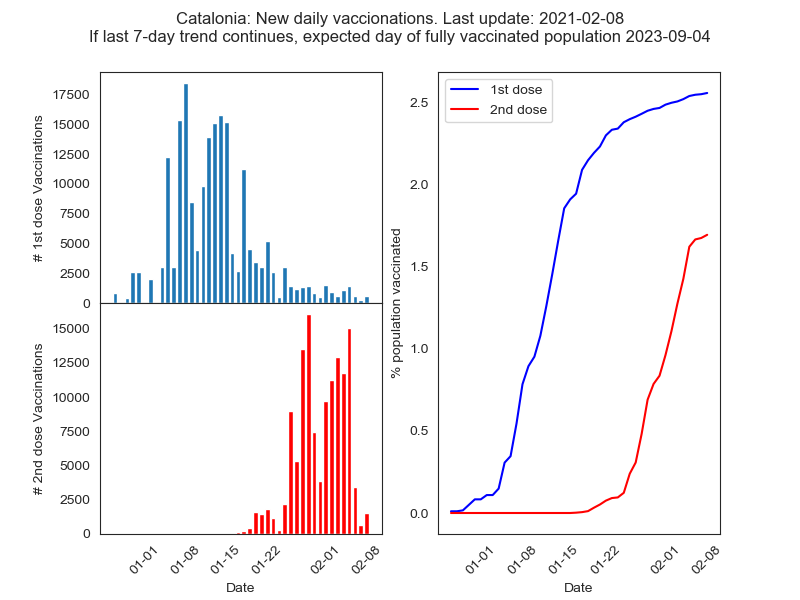

In [146]:
fig = plt.figure(figsize=(8, 6))

gs = fig.add_gridspec(2,2)

date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.suptitle("Catalonia: New daily vaccionations. Last update: " + max(dfaggvac["DATA"]).strftime("%Y-%m-%d") +
            "\nIf last 7-day trend continues, expected day of fully vaccinated population " + vaccination_end)

# Defining custom 'xlim' and 'ylim' values.
maxx = max(dfaggvac["VACUNATS_DOSI_1"].max(),dfaggvac["VACUNATS_DOSI_2"].max())
custom_ylim = (0, maxx+1000)

# Setting the values for all axes.
#plt.setp(ax1, ylim=custom_ylim)

ax1 = fig.add_subplot(gs[0, 0])

ax1.bar(x="DATA", height="VACUNATS_DOSI_1",data=dfaggvac)
ax1.set_ylabel("# 1st dose Vaccinations")
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

ax2 = fig.add_subplot(gs[1, 0]) 

ax2.bar(x="DATA", height="VACUNATS_DOSI_2",data=dfaggvac, color="red")
ax2.set_xlabel("Date")
ax2.set_ylabel("# 2nd dose Vaccinations")
ax2.xaxis.set_major_formatter(date_form)
ax2.tick_params(axis="x",rotation=45)

ax3 = fig.add_subplot(gs[:, 1])

ax3.plot(dfaggvac["DATA"], dfaggvac["1st dose percent"], color="blue", label="1st dose")
ax3.plot(dfaggvac["DATA"], dfaggvac["2nd dose percent"], color="red", label="2nd dose")

ax3.set_xlabel("Date")
ax3.set_ylabel("% population vaccinated")
ax3.xaxis.set_major_formatter(date_form)
ax3.legend()
ax3.tick_params(axis="x",rotation=45)

plt.show()
plt.savefig('CurrentOverallVaccinationCat.png')

<IPython.core.display.Javascript object>


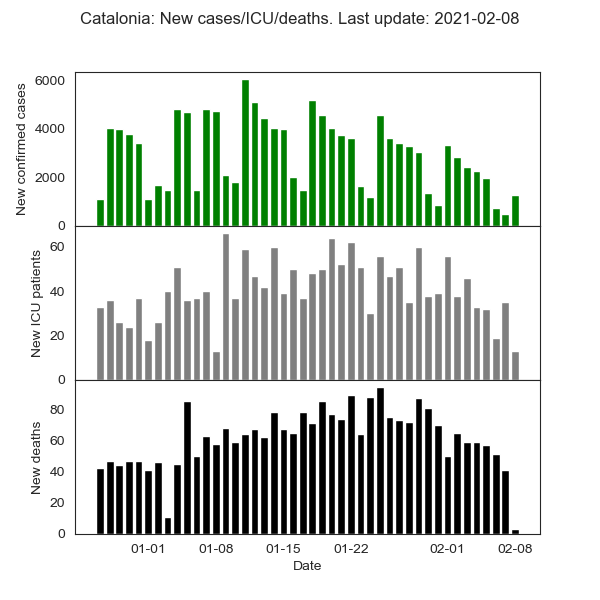

In [128]:
fig3, ax3 = plt.subplots(3,1,figsize=(6, 6), sharex=True)
date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig3.subplots_adjust(hspace=0)
fig3.suptitle("Catalonia: New cases/ICU/deaths. Last update: " + max(dfaggvac["DATA"]).strftime("%Y-%m-%d"))

ax3[0].bar(x="DATA", height="CASOS_CONFIRMAT",data=dfaggvac, color="green")
ax3[0].set_ylabel("New confirmed cases")

ax3[1].bar(x="DATA", height="INGRESSOS_CRITIC",data=dfaggvac, color="grey")
ax3[1].set_ylabel("New ICU patients")

ax3[2].bar(x="DATA", height="EXITUS",data=dfaggvac, color="black")
ax3[2].set_xlabel("Date")
ax3[2].set_ylabel("New deaths")
ax3[2].xaxis.set_major_formatter(date_form)

plt.show()
plt.savefig('CurrentCasesICUDeathsCat.png')

In [121]:
dfage = df.groupby(["DATA","GRUP_EDAT"]).agg(sum)
dfage.head()
#Població per sexe i grups d'edat: https://www.idescat.cat/pub/?id=aec&n=253


CASOS_CONFIRMAT  PCR  TAR  INGRESSOS_TOTAL  \
DATA       GRUP_EDAT                                                   
2020-03-01 Entre 15 i 64                1   12    0                0   
           Entre 65 i 74                0    4    0                0   
           Majors de 74                 0    4    0                0   
           Menors de 15                 0    0    0                0   
2020-03-02 Entre 15 i 64                4   26    0                0   

                          INGRESSOS_CRITIC  INGRESSATS_TOTAL  \
DATA       GRUP_EDAT                                           
2020-03-01 Entre 15 i 64                 0                 0   
           Entre 65 i 74                 0                 0   
           Majors de 74                  0                 0   
           Menors de 15                  0                 0   
2020-03-02 Entre 15 i 64                 0                 0   

                          INGRESSATS_CRITIC  EXITUS  CASOS_PCR  CASOS_TAR  \
DATA       GRUP_EDAT                                                        
2020-03-01 Entre 15 i 64                  0       0          1          0   
           Entre 65 i 74                  0       0          0          0   
           Majors de 74                   0       0          0          0   
           Menors de 15                   0       0          0          0   
2020-03-02 Entre 15 i 64                  0       0          4          0   

                          POSITIVITAT_PCR_NUM  POSITIVITAT_TAR_NUM  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                    0                    0   
           Entre 65 i 74                    0                    0   
           Majors de 74                     0                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                    2                    0   

                          POSITIVITAT_PCR_DEN  POSITIVITAT_TAR_DEN  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                   12                    0   
           Entre 65 i 74                    4                    0   
           Majors de 74                     4                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                   26                    0   

                          VACUNATS_DOSI_1  VACUNATS_DOSI_2  
DATA       GRUP_EDAT                                        
2020-03-01 Entre 15 i 64                0                0  
           Entre 65 i 74                0                0  
           Majors de 74                 0                0  
           Menors de 15                 0                0  
2020-03-02 Entre 15 i 64                0                0

In [122]:
#Downloaded from https://www.idescat.cat/pub/?id=aec&n=253
popdf = pd.read_html("aec-253.xls")
popdf = popdf[0]
popdf = popdf[:-4]
popdf = popdf[["Unnamed: 0", "Homes", "Dones", "Total"]]
popdf.rename(columns={"Unnamed: 0":"Age range", "Homes" : "Men", "Dones":"Women"},inplace=True)
popdf.replace({'\.':''}, regex=True,inplace=True)
popdf = popdf.astype({'Men': 'int64','Women': 'int64','Total': 'int64'})
popdf

,Age range,Men,Women,Total
0,De 0 a 4 anys,177639,168224,345863
1,De 5 a 9 anys,207060,194449,401509
2,De 10 a 14 anys,223267,208376,431643
3,De 15 a 19 anys,210527,193260,403787
4,De 20 a 24 anys,205008,191087,396095
5,De 25 a 29 anys,221110,216044,437154
6,De 30 a 34 anys,231001,235104,466105
7,De 35 a 39 anys,270896,274488,545384
8,De 40 a 44 anys,334557,325651,660208
9,De 45 a 49 anys,324031,313261,637292


In [123]:
popranges = np.sum(popdf.loc[0:3,"Total"]), np.sum(popdf.loc[3:13,"Total"]), np.sum(popdf.loc[13:15,"Total"]),np.sum(popdf.loc[15:,"Total"])
popranges = pd.Series(popranges,index=['Menors de 15','Entre 15 i 64', 'Entre 65 i 74', 'Majors de 74'])
popranges

Menors de 15     1582802
Entre 15 i 64    5462530
Entre 65 i 74    1016572
Majors de 74      725118
dtype: int64

In [124]:
dfage.reset_index(inplace=True)
dfage

,DATA,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,2020-03-01,Entre 15 i 64,1,12,0,0,0,0,0,0,1,0,0,0,12,0,0,0
1,2020-03-01,Entre 65 i 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
2,2020-03-01,Majors de 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
3,2020-03-01,Menors de 15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-03-02,Entre 15 i 64,4,26,0,0,0,0,0,0,4,0,2,0,26,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,2021-02-07,Menors de 15,44,489,357,0,0,1,0,0,18,26,21,28,468,346,0,0
1376,2021-02-08,Entre 15 i 64,893,1437,8408,1,3,845,229,0,60,833,44,693,1275,7743,518,1171
1377,2021-02-08,Entre 65 i 74,122,290,925,0,3,630,200,2,5,117,4,98,256,871,8,33
1378,2021-02-08,Majors de 74,101,412,951,1,6,957,101,1,13,88,14,75,349,871,38,297


In [125]:
dfage = dfage[dfage.DATA>=first_vaccination_date]
aggAgedf = []
for x in popranges.index:
    x1 = dfage[dfage.GRUP_EDAT==x]
    x1["1st dose percent"] =  x1["VACUNATS_DOSI_1"].cumsum()/popranges[x]*100
    x1["2nd dose percent"] =  x1["VACUNATS_DOSI_2"].cumsum()/popranges[x]*100
    
    aggAgedf.append(x1)

<IPython.core.display.Javascript object>


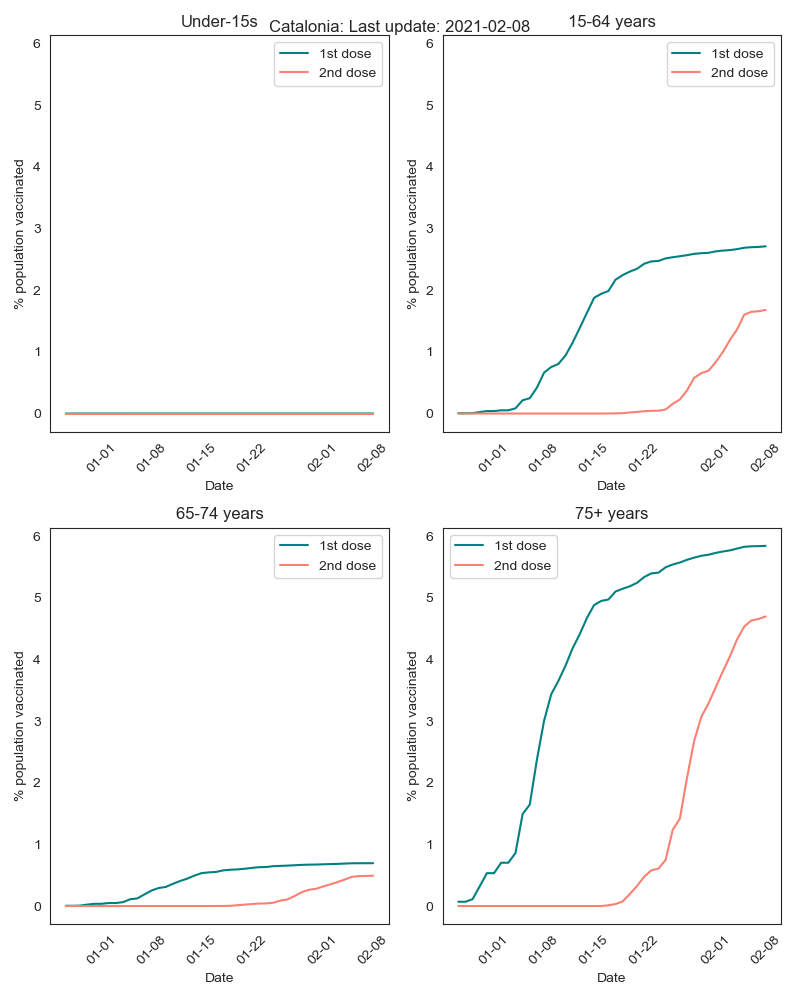

In [131]:
fig = plt.figure(figsize=(8, 10))
fig.suptitle("Catalonia: Last update: " + max(aggAgedf[0]["DATA"]).strftime("%Y-%m-%d"))

gs = fig.add_gridspec(2,2)


ax = fig.add_subplot(gs[0, 0])
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("Under-15s")


ax = fig.add_subplot(gs[0, 1], sharey=ax)
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("15-64 years")


ax = fig.add_subplot(gs[1, 0], sharey=ax)
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("65-74 years")


ax = fig.add_subplot(gs[1, 1], sharey=ax)
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("75+ years")
gs.tight_layout(fig)

plt.show()
plt.savefig('CurrentByAgeVaccinationCat.png')

'04/09/2023'